# Baysian Classification of project outcome


In this notebook will trial modelling the expected outcome of consulting projects using a Baysian logistic regression model. Will use the PyMC3 package to undertake modelling. Data will be taken from the dataset prepared in the revenue prediction project which is generated from Kimble data.

## Model training data

Initially will model the training data to test PyMC3 API.

### Import libraries + load data


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import theano
import pymc3 as pm
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, confusion_matrix


Bad key "text.kerning_factor" on line 4 in
/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("train.csv")

In [5]:
train.head()

,kimble_id,won,initial_month,finalized_month,time_to_rev,final_measured_p1,months_to_rev,p1_revenue_kimble_latest,p3_forecast_revenue_mean,p3_forecast_revenue_std,...,time_period_last_year,time_period_last_month,sales_opp_owner,delivery_manager,product,account,client_unit,split,initial_me_m,initial_me_y
0,KE010440-001,True,2019-01-01,2019-05-01,120 days 00:00:00.000000000,321848.88,4.0,321279.88,337525.250,NaN,...,2019,3,10,1,5,29,6,train,1,2019
1,KE010440-001,True,2019-01-01,2019-05-01,120 days 00:00:00.000000000,321848.88,4.0,321279.88,337665.880,198.880853,...,2019,3,10,1,5,29,6,train,1,2019
2,KE010440-001,True,2019-01-01,2019-05-01,120 days 00:00:00.000000000,321848.88,4.0,321279.88,336683.340,1707.609836,...,2019,3,10,1,5,29,6,train,1,2019
3,KE010440-001,True,2019-01-01,2019-05-01,120 days 00:00:00.000000000,321848.88,4.0,321279.88,364714.475,56079.604776,...,2019,6,10,1,5,29,6,train,1,2019
4,KE011272-001,True,2019-01-01,2019-05-01,120 days 00:00:00.000000000,919636.94,4.0,920096.31,1074507.650,NaN,...,2019,2,10,1,5,29,6,train,1,2019


In [6]:
for col in train.columns:
    print(col)

kimble_id
won
initial_month
finalized_month
time_to_rev
final_measured_p1
months_to_rev
p1_revenue_kimble_latest
p3_forecast_revenue_mean
p3_forecast_revenue_std
p3_forecast_revenue_last
p3_forecast_revenue_min
p3_forecast_revenue_max
p1_revenue_mean
p1_revenue_std
p1_revenue_last
p1_revenue_min
p1_revenue_max
level_mean
level_std
level_last
level_min
level_max
p2_resource_mean
p2_resource_std
p2_resource_last
p2_resource_min
p2_resource_max
p3_resource_mean
p3_resource_std
p3_resource_last
p3_resource_min
p3_resource_max
p2_forecast_revenue_mean
p2_forecast_revenue_std
p2_forecast_revenue_last
p2_forecast_revenue_min
p2_forecast_revenue_max
p3_cost_mean
p3_cost_std
p3_cost_last
p3_cost_min
p3_cost_max
p2_cost_mean
p2_cost_std
p2_cost_last
p2_cost_min
p2_cost_max
cost_rate_mean
cost_rate_std
cost_rate_last
cost_rate_min
cost_rate_max
adjustments_mean
adjustments_std
adjustments_last
adjustments_min
adjustments_max
sales_rate_mean
sales_rate_std
sales_rate_last
sales_rate_min
sales_rate

### Prepare data

In [7]:
def prepare_data(data):
    
    
    features = ["time_period_min_month", 
        "time_period_delta", "delivery_probability_last", "sales_rate_last", 
        "p3_forecast_revenue_last", "resource_location_nunique", "level_nunique", "p3_forecast_revenue_nunique"]
    
    data[features] = preprocessing.scale(data[features])

    data["won"] = data["won"].astype(int)
    
    return data[[
        "kimble_id", "won", "month_end", "time_period_min_month", 
        "time_period_delta", "delivery_probability_last", "sales_rate_last", 
        "p3_forecast_revenue_last", "resource_location_nunique", "level_nunique", "p3_forecast_revenue_nunique"
    ]]

In [8]:
train_simple = prepare_data(train)
train_simple.head()

,kimble_id,won,month_end,time_period_min_month,time_period_delta,delivery_probability_last,sales_rate_last,p3_forecast_revenue_last,resource_location_nunique,level_nunique,p3_forecast_revenue_nunique
0,KE010440-001,1,2019-01-01,-1.372628,0.555248,0.732291,0.232170,0.198529,0.642497,2.048015,-0.077531
1,KE010440-001,1,2019-02-01,-1.372628,0.555248,0.732291,0.248471,0.199185,0.642497,2.048015,0.178179
2,KE010440-001,1,2019-03-01,-1.372628,0.555248,0.732291,0.184402,0.191991,0.642497,2.048015,0.306034
3,KE010440-001,1,2019-04-01,-1.372628,0.555248,0.732291,0.542954,0.457733,0.642497,2.048015,0.406491
4,KE011272-001,1,2019-01-01,-1.372628,0.555248,0.732291,2.031481,1.915136,0.642497,1.361133,0.141649


In [9]:
train_simple.won.value_counts()

1    1118
0     459
Name: won, dtype: int64

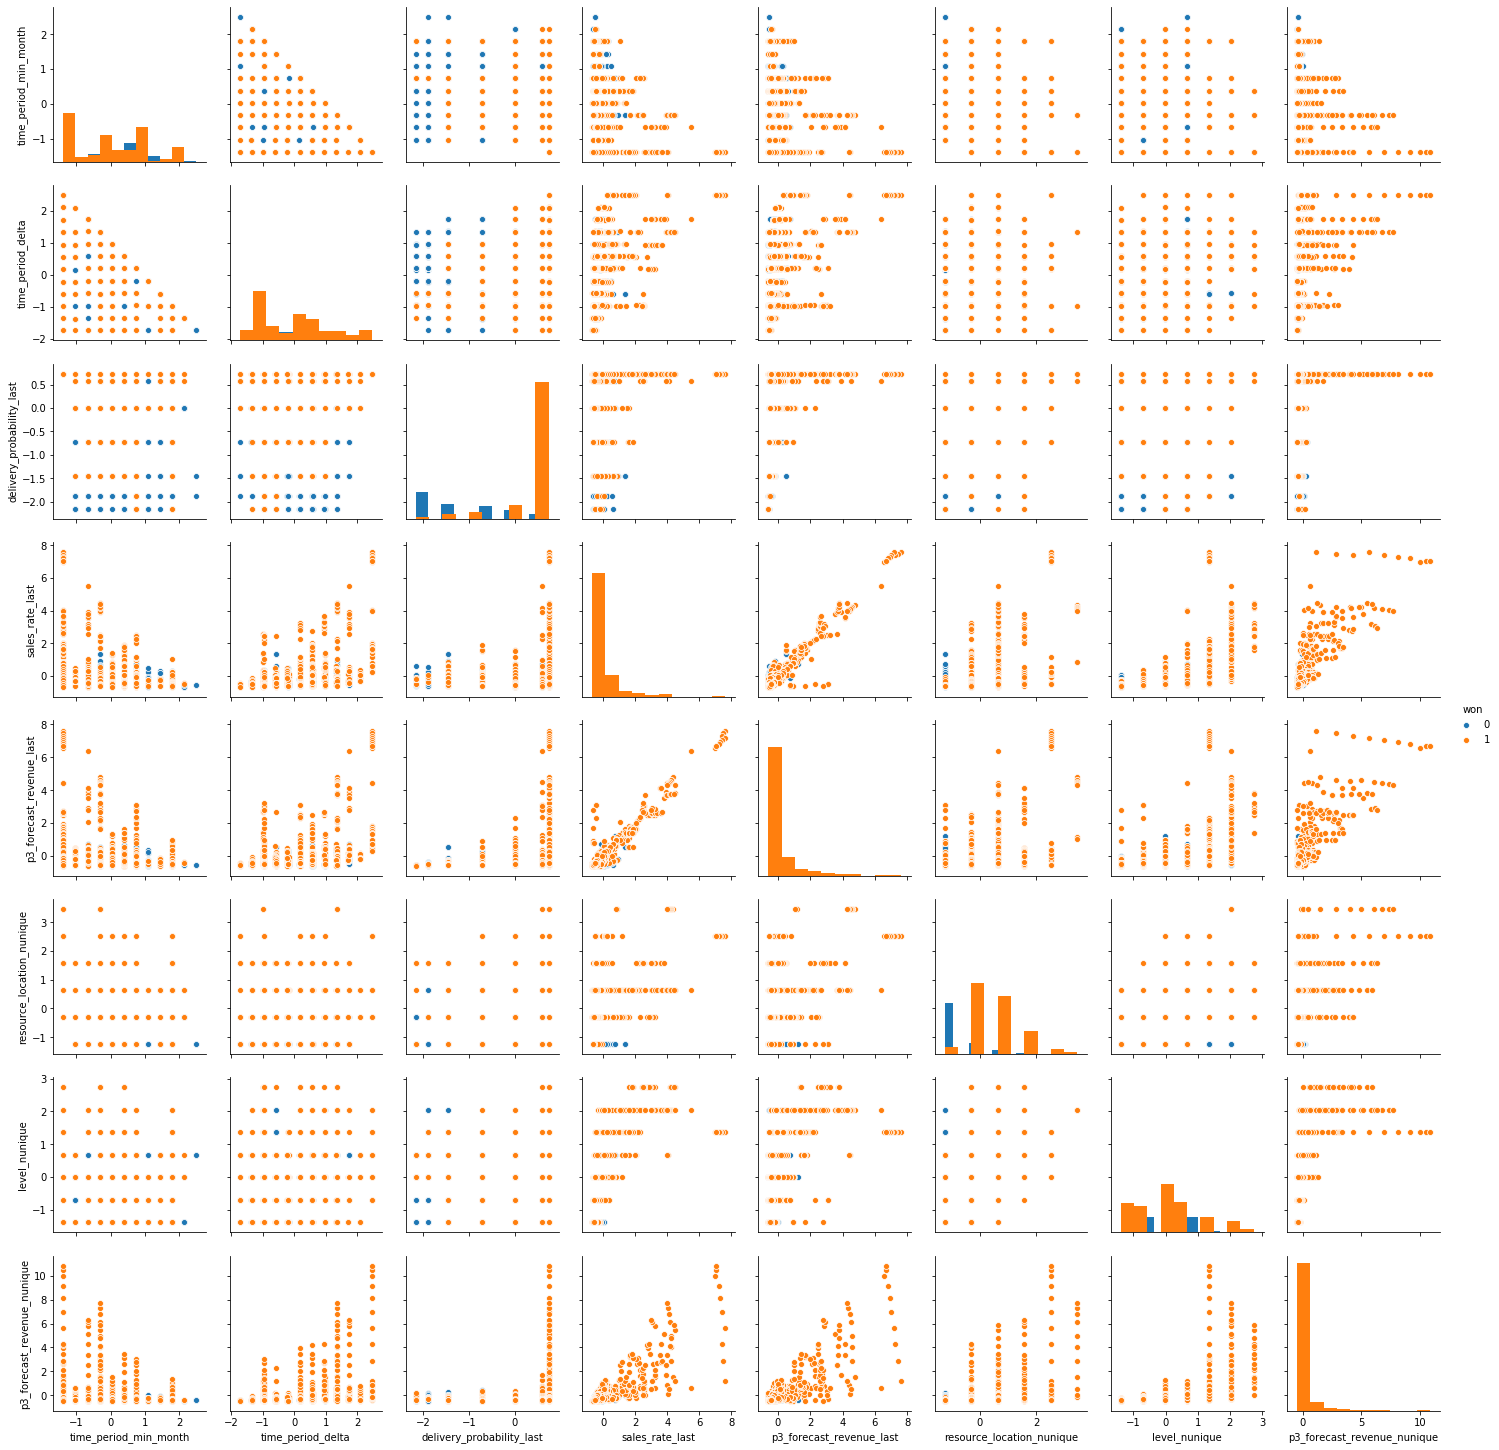

In [433]:
sns.pairplot(train_simple, hue='won', diag_kind='hist');


In [434]:
# g = sns.PairGrid(train_simple, diag_sharey=False)
# g.map_upper(sns.scatterplot, s=15)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot, lw=2)

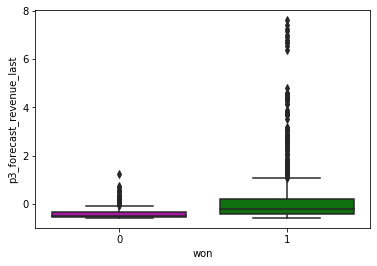

In [435]:
sns.boxplot(x="won", y="p3_forecast_revenue_last", palette=["m", "g"],
            data=train_simple)

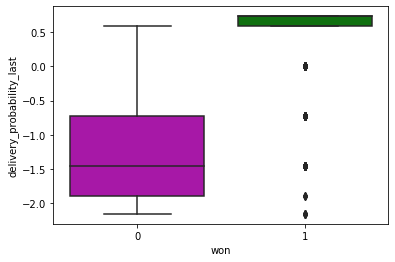

In [436]:
sns.boxplot(x="won", y="delivery_probability_last", palette=["m", "g"],
            data=train_simple)

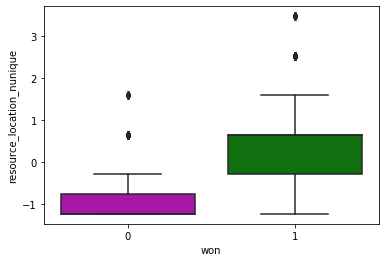

In [437]:
sns.boxplot(x="won", y="resource_location_nunique", palette=["m", "g"],
            data=train_simple)

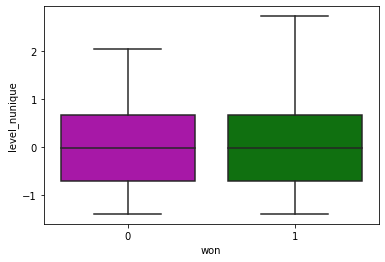

In [438]:
sns.boxplot(x="won", y="level_nunique", palette=["m", "g"],
            data=train_simple)

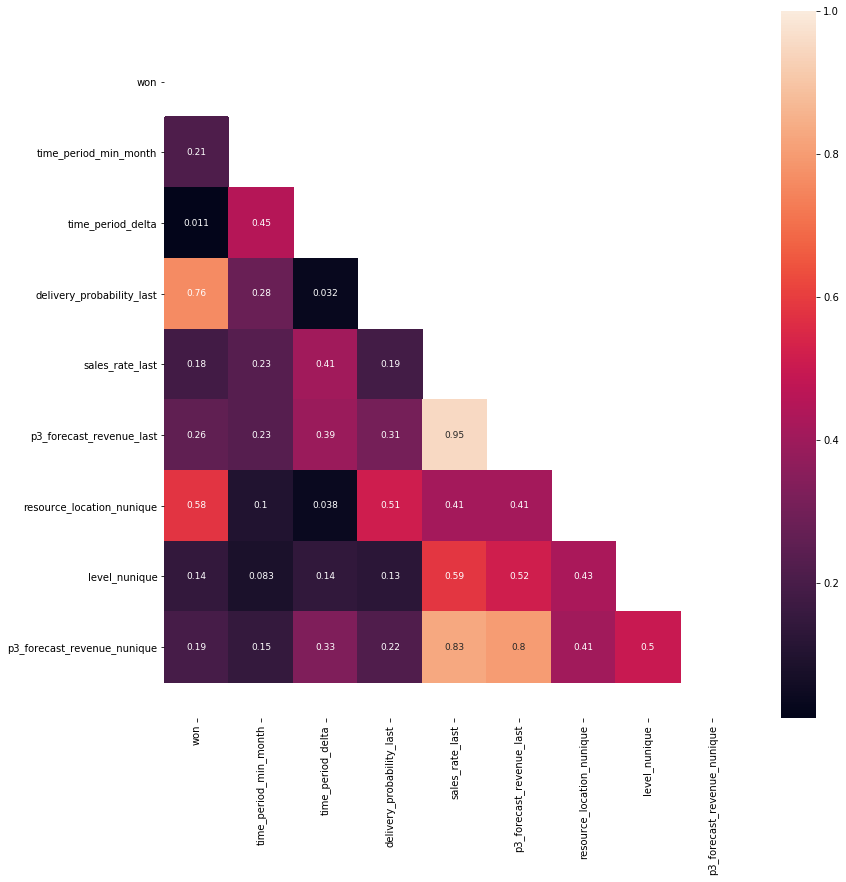

In [439]:
plt.figure(figsize=(13, 13))
corr = train_simple.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True, annot_kws={"size": 9})
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show()


In [440]:
# Try regular logisitic model on data

In [441]:
simple_model = 'won ~ resource_location_nunique + delivery_probability_last + p3_forecast_revenue_last'
full_model = 'won ~ resource_location_nunique + delivery_probability_last + p3_forecast_revenue_last + time_period_min_month + p3_forecast_revenue_nunique'

In [442]:
model = smf.logit(formula=simple_model, data=train_simple[['won', 'resource_location_nunique', 'delivery_probability_last', 'p3_forecast_revenue_last']])
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.231210
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    won   No. Observations:                 1577
Model:                          Logit   Df Residuals:                     1573
Method:                           MLE   Df Model:                            3
Date:                Mon, 17 May 2021   Pseudo R-squ.:                  0.6166
Time:                        15:04:41   Log-Likelihood:                -364.62
converged:                       True   LL-Null:                       -951.08
Covariance Type:            nonrobust   LLR p-value:                5.471e-254
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.8232      0.125     14.592      0.000       1.

In [445]:
# Try bayesian logisitic model on data

In [446]:
np.array(train_simple)[0]

array(['KE010440-001', 1, '2019-01-01', -1.3726278018196068,
       0.5552477704741109, 0.7322913815728053, 0.23217042301579857,
       0.19852945081329715, 0.6424969584746466, 2.048015470531505,
       -0.0775305853334215], dtype=object)

In [447]:
# train_shared = theano.shared(X_train)

In [493]:
simple_model

'won ~ resource_location_nunique + delivery_probability_last + p3_forecast_revenue_last'

In [449]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(simple_model,
                            train_simple,
                            family=pm.glm.families.Binomial())

In [450]:
logistic_model.basic_RVs

[Intercept,
 resource_location_nunique,
 delivery_probability_last,
 p3_forecast_revenue_last,
 y]

In [491]:
logistic_model

/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/pymc3/util.py:142: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return asscalar(value)


### Fit model

In [451]:
with logistic_model:
    trace = pm.sample(tune=1000,
                         draws=1000,
                         chains=4,
                         init = 'adapt_diag',
                         cores=1)

2021-05-17 15:04:42,531 - pymc3 - INFO - Auto-assigning NUTS sampler...
2021-05-17 15:04:42,533 - pymc3 - INFO - Initializing NUTS using adapt_diag...
2021-05-17 15:04:43,991 - pymc3 - INFO - Sequential sampling (4 chains in 1 job)
2021-05-17 15:04:43,992 - pymc3 - INFO - NUTS: [p3_forecast_revenue_last, delivery_probability_last, resource_location_nunique, Intercept]


2021-05-17 15:05:13,867 - pymc3 - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [10]:
# 4 cores would not work on my local machine
# with logistic_model:
#     trace = pm.sample(cores=4)

/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffafd4b0e50>,
      dtype=object)

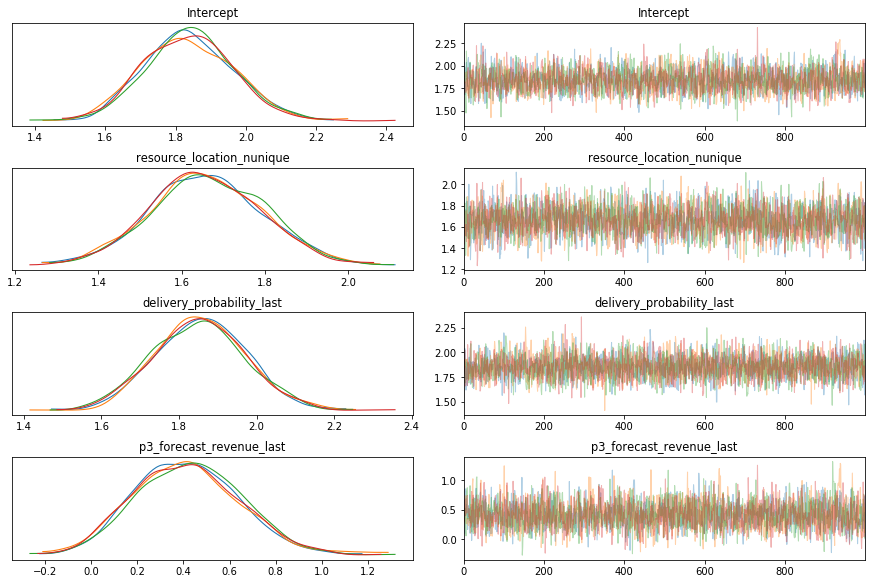

In [453]:
pm.plot_trace(trace)

In [454]:
pm.summary(trace)

/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.839,0.126,1.601,2.070,0.003,0.002,2515.0,2471.0,2548.0,2390.0,1.0
resource_location_nunique,1.661,0.134,1.411,1.912,0.003,0.002,2728.0,2719.0,2731.0,2804.0,1.0
delivery_probability_last,1.855,0.115,1.634,2.065,0.002,0.001,3383.0,3354.0,3376.0,2938.0,1.0
p3_forecast_revenue_last,0.419,0.227,0.017,0.837,0.004,0.003,2718.0,2291.0,2809.0,2706.0,1.0


## Make predictions for training data

In [455]:
ppc_train = pm.sample_posterior_predictive(trace, model=logistic_model, samples=500)

/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [456]:
ppc_train

{'y': array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]])}

In [457]:
ppc_train.keys()

dict_keys(['y'])

In [458]:
np.shape(ppc_train["y"])

(500, 1577)

The posterior distributions are sampled to get a coefficents for the logistic function used to predict project win / loss. A sample of 500 draws was generated to the shape of the posterior sample is 500 by 1577. Where there are a set of 1577 input features each with 500 values of y based on random draws of the model weights.

In [459]:
results = pd.DataFrame()

results["y_prediction"] = np.rint(ppc_train['y'].mean(axis=0)).astype('int')
results["y_score"] = np.mean(ppc_train['y'], axis=0)

In [460]:
results["win_confidence"] = results["y_score"]
results["loss_confidence"] = 1 - results["y_score"]

In [461]:
results

,y_prediction,y_score,win_confidence,loss_confidence
0,1,0.992,0.992,0.008
1,1,0.986,0.986,0.014
2,1,0.986,0.986,0.014
3,1,0.992,0.992,0.008
4,1,0.998,0.998,0.002
...,...,...,...,...
1572,1,0.760,0.760,0.240
1573,1,0.922,0.922,0.078
1574,1,0.892,0.892,0.108
1575,1,0.912,0.912,0.088


## Investigate prediction score

In [462]:
results.describe()

,y_prediction,y_score,win_confidence,loss_confidence
count,1577.000000,1577.000000,1577.000000,1577.000000
mean,0.723526,0.708857,0.708857,0.291143
std,0.447396,0.373632,0.373632,0.373632
min,0.000000,0.002000,0.002000,0.000000
25%,0.000000,0.446000,0.446000,0.016000
50%,1.000000,0.924000,0.924000,0.076000
75%,1.000000,0.984000,0.984000,0.554000
max,1.000000,1.000000,1.000000,0.998000


In [463]:
def extract_confidence(row):
    
    if row["y_prediction"] == 0:
        confidence = row["loss_confidence"]
    elif row["y_prediction"] == 1:
        confidence = row["win_confidence"]
    
    return confidence

results["confidence"] = results[["y_prediction", "win_confidence", "loss_confidence"]].apply(extract_confidence, axis=1)

In [464]:
results.loc[results.y_prediction == 0]

,y_prediction,y_score,win_confidence,loss_confidence,confidence
8,0,0.494,0.494,0.506,0.506
37,0,0.198,0.198,0.802,0.802
38,0,0.208,0.208,0.792,0.792
61,0,0.052,0.052,0.948,0.948
62,0,0.028,0.028,0.972,0.972
...,...,...,...,...,...
1548,0,0.388,0.388,0.612,0.612
1551,0,0.024,0.024,0.976,0.976
1552,0,0.148,0.148,0.852,0.852
1558,0,0.042,0.042,0.958,0.958


# Calculate classification performance

In [465]:
results["y_obs"] =  train_simple["won"]

In [466]:
recall =  recall_score(results["y_obs"], results["y_prediction"])
precision = precision_score(results["y_obs"], results["y_prediction"])

In [467]:
confusion_matrix(results["y_obs"], results["y_prediction"])

array([[ 375,   84],
       [  61, 1057]])

## Check average confidence of each classication group, i.e. tp, tn, fp, fn

In [468]:
def mark_classification_error(row):
    
    if row["y_obs"] == 0 and row["y_prediction"] == 0:
        return "tn"
    elif row["y_obs"] == 0 and row["y_prediction"] == 1:
        return "fp"
    elif row["y_obs"] == 1 and row["y_prediction"] == 1:
        return "tp"
    elif row["y_obs"] == 1 and row["y_prediction"] == 0:
        return "fn"
    

results["classification_error"] = results[["y_prediction", "y_obs"]].apply(mark_classification_error, axis=1)

In [469]:
results.sample(10)

,y_prediction,y_score,win_confidence,loss_confidence,confidence,y_obs,classification_error
1432,1,0.902,0.902,0.098,0.902,1,tp
844,1,0.942,0.942,0.058,0.942,1,tp
482,1,0.990,0.990,0.010,0.990,1,tp
114,1,0.934,0.934,0.066,0.934,1,tp
252,1,0.946,0.946,0.054,0.946,1,tp
1480,1,0.928,0.928,0.072,0.928,1,tp
1111,1,0.910,0.910,0.090,0.910,1,tp
1105,1,0.900,0.900,0.100,0.900,1,tp
317,1,0.928,0.928,0.072,0.928,1,tp
1517,1,0.918,0.918,0.082,0.918,1,tp


In [470]:
len(results)

1577

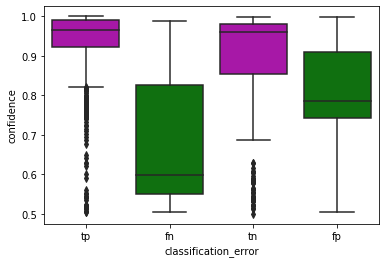

In [471]:
sns.boxplot(x="classification_error", y="confidence", palette=["m", "g"],
            data=results)

This result indicates that for this classification which is designed to lead to a decision would make sense to use an uncertainty filter which would remove a lot of the incorrect predictions.

In [472]:
confidence_threshold = 0.85

results_confident = results.loc[results["confidence"] >= confidence_threshold]

print("With a threshold of: {} we are confident about the outcome of {:.0f}% of projects".format(
    confidence_threshold, 100*(len(results_confident) / len(results))))

With a threshold of: 0.85 we are confident about the outcome of 81% of projects


In [473]:
confusion_matrix(results_confident["y_obs"], results_confident["y_prediction"])

array([[290,  27],
       [  7, 955]])

# Run prediction with test and train data

Now will train the model with training data + then evaluate with test data.

In [474]:
def prepare_data(data):
    
    
    features = ["time_period_min_month", 
        "time_period_delta", "delivery_probability_last", "sales_rate_last", 
        "p3_forecast_revenue_last", "resource_location_nunique", "level_nunique", "p3_forecast_revenue_nunique"]
    
    data[features] = preprocessing.scale(data[features])

    data["won"] = data["won"].astype(int)
    
    return data[[
        "won", "time_period_min_month", 
        "time_period_delta", "delivery_probability_last", "sales_rate_last", 
        "p3_forecast_revenue_last", "resource_location_nunique", "level_nunique", "p3_forecast_revenue_nunique"
    ]]

In [475]:
train_simple = prepare_data(train)
test_simple = prepare_data(test_simple)

In [476]:
train_simple.dtypes

won                              int64
time_period_min_month          float64
time_period_delta              float64
delivery_probability_last      float64
sales_rate_last                float64
p3_forecast_revenue_last       float64
resource_location_nunique      float64
level_nunique                  float64
p3_forecast_revenue_nunique    float64
dtype: object

In [477]:
np.shape(train_simple.values)

(1577, 9)

### Note

To use multiple sets of X features in a PyMC3 model must set the input features as a theano shared object. This allows the object to updated later to change the input features.

In [495]:
data_shared = theano.shared(train_simple)

In [496]:
X_shared.container.storage[0]

array([[-1.3726278 ,  0.55524777,  0.73229138, ...,  0.64249696,
         2.04801547, -0.07753059],
       [-1.3726278 ,  0.55524777,  0.73229138, ...,  0.64249696,
         2.04801547,  0.17817904],
       [-1.3726278 ,  0.55524777,  0.73229138, ...,  0.64249696,
         2.04801547,  0.30603386],
       ...,
       [ 1.79152786, -1.73289571,  0.58650242, ..., -0.29740815,
        -1.38639584, -0.47022752],
       [ 1.79152786, -0.96175343,  0.58650242, ..., -0.29740815,
        -1.38639584, -0.43369757],
       [ 2.14310071, -1.35364541,  0.73229138, ...,  0.64249696,
        -0.01263132, -0.4154326 ]])

In [518]:
X_train = train_simple[X_cols]

for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col])
    
    
y_train = train_simple["won"]

/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [519]:
X_train.head()

,time_period_min_month,time_period_delta,delivery_probability_last,sales_rate_last,p3_forecast_revenue_last,resource_location_nunique,level_nunique,p3_forecast_revenue_nunique
0,-1.372628,0.555248,0.732291,0.232170,0.198529,0.642497,2.048015,-0.077531
1,-1.372628,0.555248,0.732291,0.248471,0.199185,0.642497,2.048015,0.178179
2,-1.372628,0.555248,0.732291,0.184402,0.191991,0.642497,2.048015,0.306034
3,-1.372628,0.555248,0.732291,0.542954,0.457733,0.642497,2.048015,0.406491
4,-1.372628,0.555248,0.732291,2.031481,1.915136,0.642497,1.361133,0.141649


In [520]:
X_train.dtypes

time_period_min_month          float64
time_period_delta              float64
delivery_probability_last      float64
sales_rate_last                float64
p3_forecast_revenue_last       float64
resource_location_nunique      float64
level_nunique                  float64
p3_forecast_revenue_nunique    float64
dtype: object

In [521]:
X_train.p3_forecast_revenue_nunique.dtype

dtype('float64')

In [522]:
X_train_np = X_train.values

In [523]:
X_train_np

array([[-1.3726278 ,  0.55524777,  0.73229138, ...,  0.64249696,
         2.04801547, -0.07753059],
       [-1.3726278 ,  0.55524777,  0.73229138, ...,  0.64249696,
         2.04801547,  0.17817904],
       [-1.3726278 ,  0.55524777,  0.73229138, ...,  0.64249696,
         2.04801547,  0.30603386],
       ...,
       [ 1.79152786, -1.73289571,  0.58650242, ..., -0.29740815,
        -1.38639584, -0.47022752],
       [ 1.79152786, -0.96175343,  0.58650242, ..., -0.29740815,
        -1.38639584, -0.43369757],
       [ 2.14310071, -1.35364541,  0.73229138, ...,  0.64249696,
        -0.01263132, -0.4154326 ]])

In [524]:
np.dtype((X_train_np[0][0]))

dtype('float64')

In [525]:
X_shared = theano.shared(X_train_np)

In [526]:
X_shared

<TensorType(float64, matrix)>

In [527]:
np.shape(X_shared.container.storage[0])

(1577, 8)

In [528]:
len(y_train)

1577

In [529]:
with pm.Model() as logistic_model_shared:
    pm.glm.GLM(x=X_shared,
               y=y_train,
               labels=X_cols,
               family=pm.glm.families.Binomial())

In [530]:
X_cols

['time_period_min_month',
 'time_period_delta',
 'delivery_probability_last',
 'sales_rate_last',
 'p3_forecast_revenue_last',
 'resource_location_nunique',
 'level_nunique',
 'p3_forecast_revenue_nunique']

In [531]:
logistic_model_shared.basic_RVs

[Intercept,
 time_period_min_month,
 time_period_delta,
 delivery_probability_last,
 sales_rate_last,
 p3_forecast_revenue_last,
 resource_location_nunique,
 level_nunique,
 p3_forecast_revenue_nunique,
 y]

In [532]:
logistic_model_shared

/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/pymc3/util.py:142: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return asscalar(value)


The model appears to have been intiated correctly. Parameters are as expected.

In [533]:
### Train model on training dataset

In [534]:
with logistic_model_shared:
    trace_train = pm.sample(tune=1000,
                         draws=1000,
                         chains=4,
                         init = 'adapt_diag',
                         cores=1)

2021-05-17 15:23:34,764 - pymc3 - INFO - Auto-assigning NUTS sampler...
2021-05-17 15:23:34,767 - pymc3 - INFO - Initializing NUTS using adapt_diag...
2021-05-17 15:23:36,914 - pymc3 - INFO - Sequential sampling (4 chains in 1 job)
2021-05-17 15:23:36,915 - pymc3 - INFO - NUTS: [p3_forecast_revenue_nunique, level_nunique, resource_location_nunique, p3_forecast_revenue_last, sales_rate_last, delivery_probability_last, time_period_delta, time_period_min_month, Intercept]


2021-05-17 15:24:18,240 - pymc3 - INFO - Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb16e8af10>,
      dtype=object)

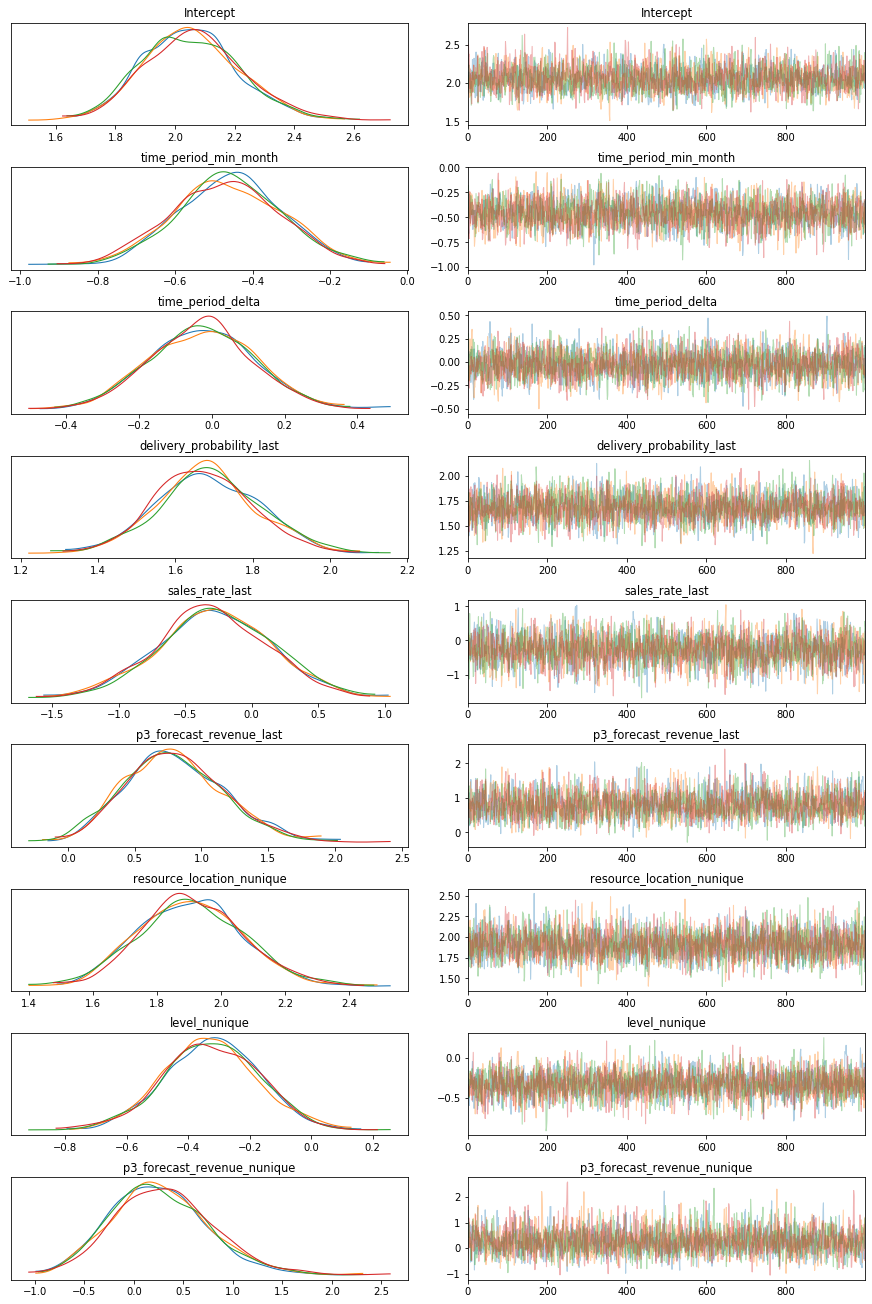

In [535]:
pm.plot_trace(trace_train)

In [536]:
### Make predictions for training data

In [537]:
ppc_train = pm.sample_posterior_predictive(
    trace_train,
    model=logistic_model_shared,
    samples=500)

/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [538]:
ppc_train

{'y': array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 0, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 0, 1]])}

In [539]:
np.shape(ppc_train["y"])

(500, 1577)

In [540]:
results_train = pd.DataFrame()
results_train["y_prediction"] = np.rint(ppc_train['y'].mean(axis=0)).astype('int')
results_train["y_score"] = np.mean(ppc_train['y'], axis=0)
results_train["win_confidence"] = results_train["y_score"]
results_train["loss_confidence"] = 1 - results_train["y_score"]
results_train["y_obs"] =  train_simple["won"]

In [541]:
len(results_train)

1577

### Prepare test data

Note: must reasssign the value of X_shared using the set_value method.

In [542]:
# Slice X and y data
X_test = test_simple[X_cols]
y_test = test_simple["won"]

# Convert all values to numeric
for col in X_test.columns:
    X_test[col] = pd.to_numeric(X_test[col])

# Convert values to numpy array
X_test_np = X_test.values

# Set X_shared as test data
X_shared.set_value(X_test_np)

/Users/smro/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [543]:
print("X_test_np shape:", np.shape(X_test_np))
print("X_shared shape:", np.shape(X_shared.container.storage[0]))

X_test_np shape: (1281, 8)
X_shared shape: (1281, 8)


In [544]:
### Make predictions for test data

In [545]:
ppc_test = pm.sample_posterior_predictive(
    trace_train,
    model=logistic_model_shared,
    samples=500)

In [546]:
ppc_test

{'y': array([[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 0],
        [0, 0, 1, ..., 0, 1, 1]])}

In [547]:
np.shape(ppc_test["y"])

(500, 1281)

In [548]:
len(X_test)

1281

Not sure why this is still the same length as previous prediction? Has it actually predicted for test features?

In [549]:
results_test = pd.DataFrame()

results_test["y_prediction"] = np.rint(ppc_test['y'].mean(axis=0)).astype('int')
results_test["y_score"] = np.mean(ppc_test['y'], axis=0)
results_test["win_confidence"] = results_test["y_score"]
results_test["loss_confidence"] = 1 - results_test["y_score"]
results_test["y_obs"] =  test_simple["won"]

In [550]:
def extract_confidence(row):
    
    if row["y_prediction"] == 0:
        confidence = row["loss_confidence"]
    elif row["y_prediction"] == 1:
        confidence = row["win_confidence"]
    
    return confidence

results_test["confidence"] = results_test[["y_prediction", "win_confidence", "loss_confidence"]].apply(extract_confidence, axis=1)

In [551]:
def mark_classification_error(row):
    
    if row["y_obs"] == 0 and row["y_prediction"] == 0:
        return "tn"
    elif row["y_obs"] == 0 and row["y_prediction"] == 1:
        return "fp"
    elif row["y_obs"] == 1 and row["y_prediction"] == 1:
        return "tp"
    elif row["y_obs"] == 1 and row["y_prediction"] == 0:
        return "fn"
    

results_test["classification_error"] = results_test[["y_prediction", "y_obs"]].apply(mark_classification_error, axis=1)

In [552]:
len(results_test)

1281

In [553]:
results_test.head()

,y_prediction,y_score,win_confidence,loss_confidence,y_obs,confidence,classification_error
0,0,0.080,0.080,0.920,0,0.920,tn
1,0,0.166,0.166,0.834,0,0.834,tn
2,0,0.152,0.152,0.848,0,0.848,tn
3,0,0.202,0.202,0.798,0,0.798,tn
4,0,0.162,0.162,0.838,0,0.838,tn


In [554]:
results_test.classification_error.value_counts()

tp    505
tn    416
fp    318
fn     42
Name: classification_error, dtype: int64

In [555]:
results_test.y_obs.value_counts()

0    734
1    547
Name: y_obs, dtype: int64

In [556]:
results_test["y_prediction"]

0       0
1       0
2       0
3       0
4       0
       ..
1276    0
1277    0
1278    0
1279    0
1280    0
Name: y_prediction, Length: 1281, dtype: int64

In [557]:
ppc_test

{'y': array([[0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 0],
        [0, 0, 1, ..., 0, 1, 1]])}

In [558]:
confusion_matrix(results_test["y_obs"], results_test["y_prediction"])

array([[416, 318],
       [ 42, 505]])

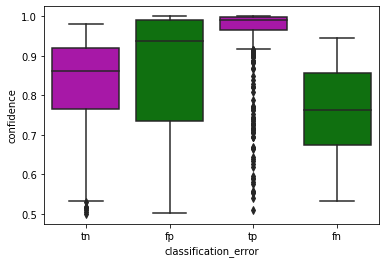

In [559]:
sns.boxplot(x="classification_error", y="confidence", palette=["m", "g"],
            data=results_test)

In [560]:
confidence_threshold = 0.8

results_confident = results_test.loc[results_test["confidence"] >= confidence_threshold]

print("With a threshold of: {} we are confident about the outcome of {:.0f}% of projects".format(
    confidence_threshold, 100*(len(results_confident) / len(results))))

With a threshold of: 0.8 we are confident about the outcome of 62% of projects


In [561]:
confusion_matrix(results_confident["y_obs"], results_confident["y_prediction"])

array([[285, 218],
       [ 17, 459]])

In [562]:
recall_score(results_confident["y_obs"], results_confident["y_prediction"])

0.9642857142857143

In [563]:
precision_score(results_confident["y_obs"], results_confident["y_prediction"])

0.6779911373707533

## TODO

- Think about how model could be updated with monthly data dumps.
- Look at ordinal logistic regression for defining decision boundaries.


    
    

Good video on ordinal logistic regression - https://www.youtube.com/watch?v=fxydbmTfsk4&t=2000s


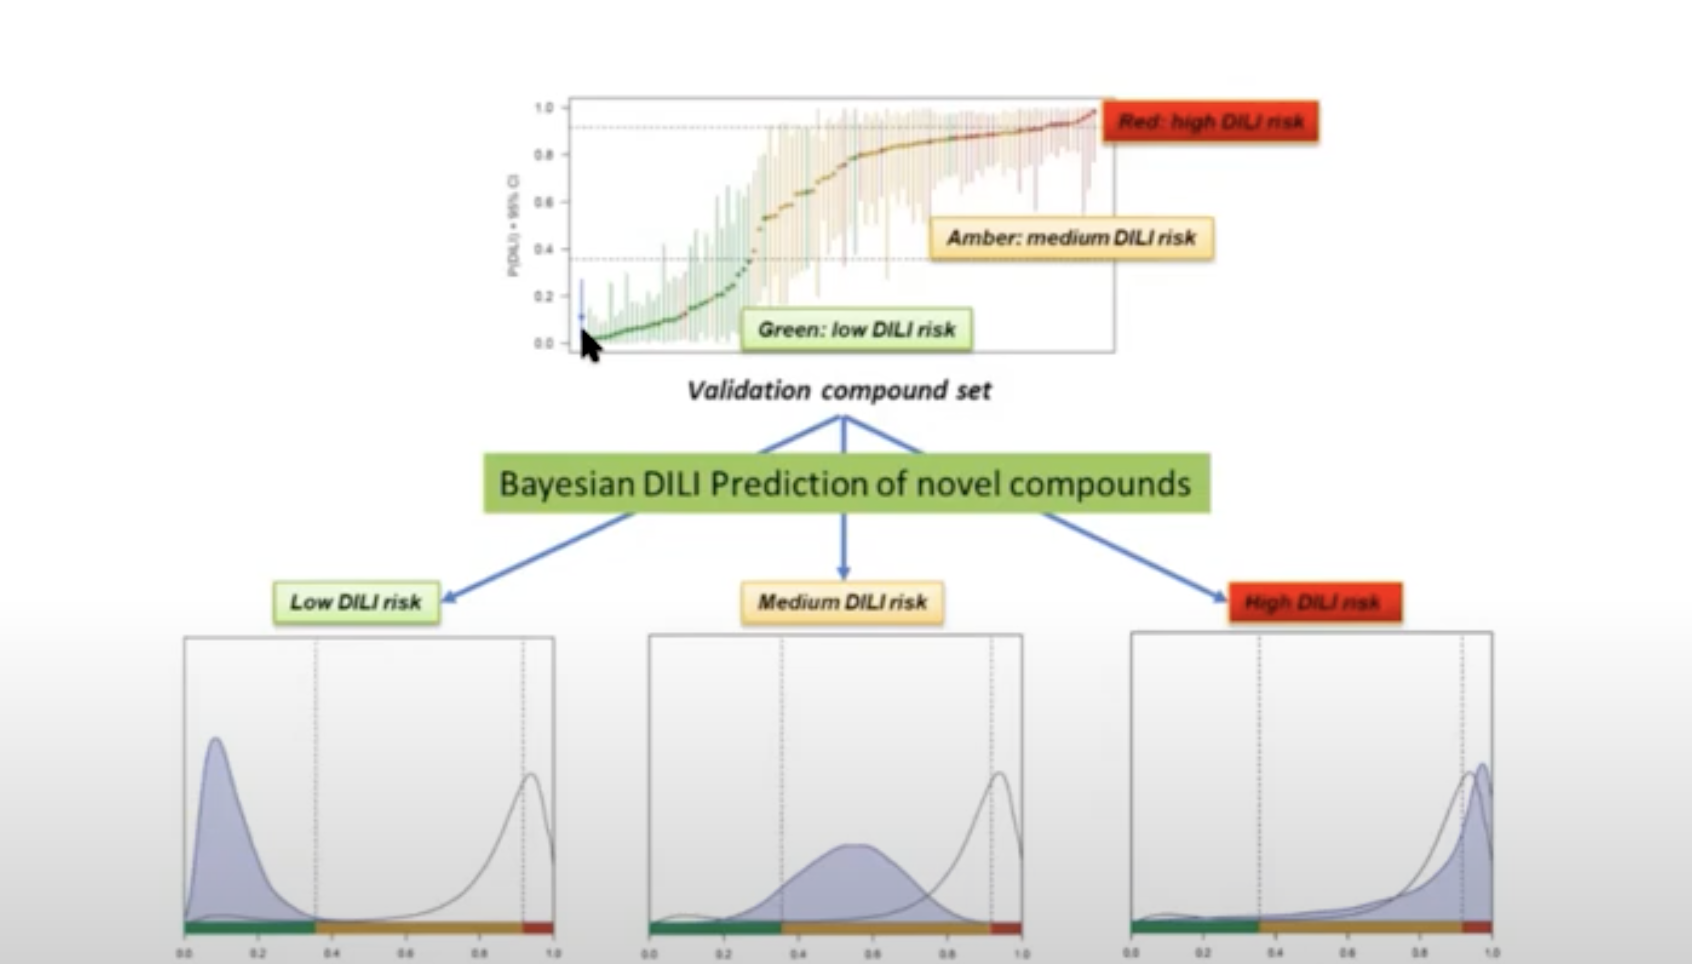